<a href="https://www.kaggle.com/yangleotrino/project-1-mnist-kaggle?scriptVersionId=86003846" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm
import requests
import pathlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cuda:0


In [4]:
# I/O
import gzip
import pickle
from pathlib import Path

# create dir
DATA_PATH = Path('my_data')
DATA_PATH.mkdir(exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (DATA_PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (DATA_PATH/FILENAME).open('wb').write(content) # download to my own dir!

with gzip.open('my_data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin-1')

In [5]:
# read numpy arrays and convert to tensor
X_train, y_train = train_set
X_val, y_val = valid_set
X_test, y_test = test_set

X_train, y_train, X_val, y_val, X_test, y_test = map(torch.from_numpy, [X_train, y_train, X_val, y_val, X_test, y_test])
X_train, y_train, X_val, y_val, X_test, y_test = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device), X_test.to(device), y_test.to(device)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([50000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])


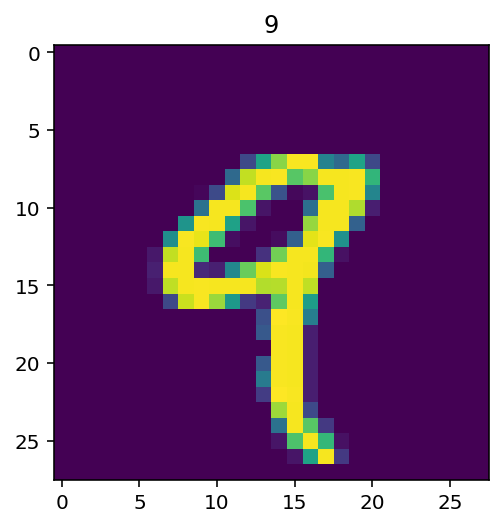

In [6]:
# visualization
plt.imshow(X_train.cpu()[4].reshape(28,28))
plt.title(y_train[4].item())
plt.show()

In [7]:
# Dataset and DataLoader 
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 50
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# NN model

class mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin_1 = nn.Linear(784, 50)
        self.lin_2 = nn.Linear(50, 20)
        self.lin_3 = nn.Linear(20, 10)
        
    def forward(self, xb):
        xb = F.relu(self.lin_1(xb))
        xb = F.relu(self.lin_2(xb))
        xb = F.relu(self.lin_3(xb))
        return xb

# CNN model
class mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1) # in_channel, out_channel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # the first dimension (batch size) is inferred. dim: [N, C, H, W]
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        # print(xb.shape)
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [9]:
# initialize model
model_nn = mnist_NN().to(device)
model_cnn = mnist_CNN().to(device)

In [10]:
model_cnn(X_train[0])

tensor([[0.0002, 0.0000, 0.0217, 0.0076, 0.0422, 0.0006, 0.0270, 0.1515, 0.0154,
         0.0553]], device='cuda:0', grad_fn=<ViewBackward>)

In [11]:
# loss function. Softmax is computed inside cross_entrpy.
loss_function = F.cross_entropy

In [12]:
# optimizer for updating weights
optimizer_nn = optim.SGD(params=model_nn.parameters(), lr=0.2, momentum=0.9)
optimizer_cnn = optim.SGD(params=model_cnn.parameters(), lr=0.1, momentum=0.9)

In [13]:
# training!
def training(my_model, my_optimizer):
    epochs = 30
    train_loss = []
    val_loss = []
    it = []
    for epoch in tqdm(range(epochs)):
        it.append(epoch)
        my_model.train() # set mode, not actually training
        for i, mini_batch in enumerate(train_dataloader):
            xb, yb = mini_batch
            xb = xb.to(device)
            yb = yb.to(device)
            pred = my_model(xb)
            loss = loss_function(pred, yb)
            
            my_optimizer.zero_grad()
            loss.backward()
            my_optimizer.step()

        my_model.eval()

        with torch.no_grad():

            tmp_train_loss = sum(loss_function(my_model(xb.to(device)), yb.to(device)) for xb, yb in train_dataloader).item()/len(train_dataset)
            tmp_val_loss = sum(loss_function(my_model(xb.to(device)), yb.to(device)) for xb, yb in val_dataloader).item()/len(val_dataset)
#             print('epoch ' + str(epoch))
#             print('train err: ' + str(np.round(tmp_train_loss,4)) + ', val err: ' + str(np.round(tmp_val_loss,4)))
            train_loss.append(tmp_train_loss)
            val_loss.append(tmp_val_loss)

    return my_model, train_loss, val_loss, it

In [14]:
trained_model_cnn, lt, lv, it = training(model_cnn, optimizer_cnn)

100%|██████████| 30/30 [01:28<00:00,  2.94s/it]


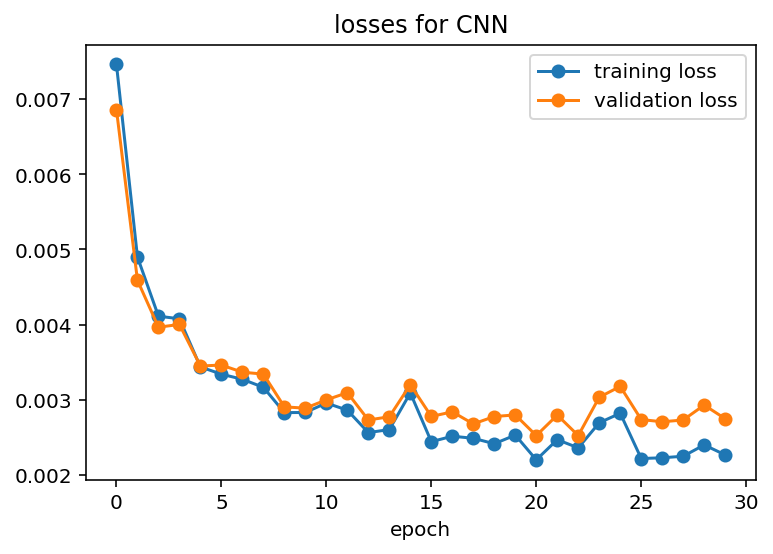

In [15]:
plt.plot(it, lt, 'o-', label='training loss')
plt.plot(it, lv, 'o-', label='validation loss')
plt.legend()
plt.title('losses for CNN')
plt.xlabel('epoch')
plt.show()

In [16]:
# output accuracy, CNN
y_train_pred = trained_model_cnn(X_train)
y_val_pred = trained_model_cnn(X_val)
y_test_pred = trained_model_cnn(X_test)

print('train accuracy (CNN): ' + str((y_train_pred.argmax(dim=1) == y_train).float().mean().item()))
print('val accuracy (CNN): ' + str((y_val_pred.argmax(dim=1) == y_val).float().mean().item()))
print('test accuracy (CNN): ' + str((y_test_pred.argmax(dim=1) == y_test).float().mean().item()))

train accuracy (CNN): 0.9647799730300903
val accuracy (CNN): 0.9616999626159668
test accuracy (CNN): 0.9607999920845032
